In [29]:
import pandas as pd
import numpy as np
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, Subset
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import shutil
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from collections import Counter
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

In [3]:
base_dir = 'data'
# Output directory to store the split data
output_dir = 'HistopathologySplit'

In [5]:
# Function to move files to respective directories
def move_files(file_paths, labels, destination):
    for file_path, label in zip(file_paths, labels):
        label_dir = os.path.join(destination, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.move(file_path, label_dir)

In [9]:
# Create training, validation, and test directories
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Initialize lists for image paths and labels
image_paths = []
labels = []

# Collect image file paths and labels
for patient_id in os.listdir(base_dir):
    patient_path = os.path.join(base_dir, patient_id)
    
    if os.path.isdir(patient_path):
        for label in ['0', '1']:
            label_dir = os.path.join(patient_path, label)
            if os.path.isdir(label_dir):
                for image_name in os.listdir(label_dir):
                    image_path = os.path.join(label_dir, image_name)
                    image_paths.append(image_path)
                    labels.append(label)

# Show class distribution that indicates 3 to 1 benign vs disease imbalance
counts = Counter(labels)
print(counts)

Counter({'0': 198738, '1': 78786})


In [10]:
# Create a stratified train-validation-test split (70% train, 20% validation, 10% test) using labels
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

# Further split the temp set into validation and test (2/3 for validation, 1/3 for test)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=1/3, stratify=temp_labels, random_state=42
)

# Move training, validation, and test files
move_files(train_paths, train_labels, train_dir)
move_files(val_paths, val_labels, val_dir)
move_files(test_paths, test_labels, test_dir)

print(f"Training, validation, and test datasets created at '{output_dir}'.")
print(f"Number of training images: {len(train_paths)}")
print(f"Number of validation images: {len(val_paths)}")
print(f"Number of test images: {len(test_paths)}")

Training, validation, and test datasets created at 'HistopathologySplit'.
Number of training images: 194266
Number of validation images: 55505
Number of test images: 27753


In [4]:
# Define image transformations for the training and validation datasets
train_transforms = transforms.Compose([
    transforms.Resize((50, 50)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                       
])

val_transforms = transforms.Compose([
    transforms.Resize((50, 50)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((50, 50)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
# Load the dataset with the defined transformations
train_dataset = datasets.ImageFolder(root=f'{output_dir}/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root=f'{output_dir}/val', transform=val_transforms)
test_dataset = datasets.ImageFolder(root=f'{output_dir}/test', transform=test_transforms)

# Extract class labels from the dataset
targets = train_dataset.targets

# Calculate class weights, which are the inverse of class frequencies. Classes with fewer samples will get assigned a higher 
# weight (ensuring that the minority class receives a higher weight, making it more likely to be sampled during training).
class_counts = np.bincount(targets)  # Count the number of samples per class
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

sample_weights = torch.tensor([class_weights[label] for label in targets], dtype=torch.float)

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [5]:
class CNN(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super(CNN, self).__init__()

        # First Convolutional Block for 3 input channels RGB
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32) #Normalizes the convolution output to have a mean close to 0 and a standard deviation close to 1.
        self.dropout1 = nn.Dropout2d(dropout)  # Apply dropout on feature maps

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(dropout)  # Apply dropout on feature maps

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(dropout)  # Apply dropout on feature maps

        # Fully Connected Layer Block. Second FC layer will output the number of classes.
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout_fc = nn.Dropout(dropout)  # Apply dropout after fully connected layer

        # Leaky ReLU Activation
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        # Apply the first convolutional block
        x = self.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Apply the second convolutional block
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Apply the third convolutional block
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten the output of the convolutional layers
        x = x.view(-1, 128 * 6 * 6)

        # Fully connected layers
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

In [6]:
# Define learning rate scheduler with warmup period
def get_linear_warmup_scheduler(optimizer, base_lr, num_epochs, num_warmup=3):
    def lr_lambda(epoch):
        return min(1.0, (epoch+1) / num_warmup)

    return lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Halve learning rate if loss doesn't improve after 3 epochs
def get_plateau_scheduler(optimizer):
    return lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5, # halve the loss
        threshold=1e-4,
        patience=3) # apply after 3 epochs of non-improving loss

In [12]:
# Configure hyperparameters
best_model_path = "best_model.pth"
criterion = nn.CrossEntropyLoss(weight=class_weights)
learning_rate = 0.001
weight_decay = 0.001
batch_size = 32
num_output_classes = 2 # benign or disease
dropout = 0.5
model = CNN(num_output_classes, dropout)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 10

warmup_epochs = 3
warmup_scheduler = get_linear_warmup_scheduler(optimizer, learning_rate, num_epochs, warmup_epochs)
plateau_scheduler = get_plateau_scheduler(optimizer)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_

In [13]:
# Create DataLoaders with the sampler for training
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)

# Create DataLoader for validation and test without a sampler
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [14]:
# Training loop
best_val_loss = float('inf')
best_val_f1 = -1.0
all_training_losses = []
all_training_f1 = []
all_validation_losses = []
all_validation_f1 = []

for epoch in range(num_epochs):
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    all_preds = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(train_loader)
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    all_training_losses.append(avg_train_loss)
    all_training_f1.append(train_f1)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train F1: {train_f1:.2f}")

    # Validation step
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        all_val_preds = []
        all_val_labels = []
        
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
            
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
    all_validation_losses.append(avg_val_loss)
    all_validation_f1.append(val_f1)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation F1: {val_f1:.2f}\n")

    # Save the model if validation F1 has improved
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved with validation F1: {best_val_f1:.4f}")

    # Step the scheduler at the end of each epoch
    if warmup_scheduler and epoch < warmup_epochs:
        warmup_scheduler.step()
    elif plateau_scheduler and epoch >= warmup_epochs:
        plateau_scheduler.step(val_f1)

Learning Rate: 0.000333
Epoch [1/10], Train Loss: 0.4753, Train F1: 0.67
Validation Loss: 0.7238, Validation F1: 0.62

Model saved with validation F1: 0.6200
Learning Rate: 0.000667
Epoch [2/10], Train Loss: 0.4269, Train F1: 0.73
Validation Loss: 0.7430, Validation F1: 0.64

Model saved with validation F1: 0.6365
Learning Rate: 0.001000
Epoch [3/10], Train Loss: 0.4150, Train F1: 0.74
Validation Loss: 0.6553, Validation F1: 0.67

Model saved with validation F1: 0.6670
Learning Rate: 0.001000
Epoch [4/10], Train Loss: 0.4024, Train F1: 0.76
Validation Loss: 0.5278, Validation F1: 0.71

Model saved with validation F1: 0.7095
Learning Rate: 0.001000
Epoch [5/10], Train Loss: 0.3982, Train F1: 0.76
Validation Loss: 0.4993, Validation F1: 0.73

Model saved with validation F1: 0.7266
Learning Rate: 0.001000
Epoch [6/10], Train Loss: 0.3948, Train F1: 0.76
Validation Loss: 0.5511, Validation F1: 0.69

Learning Rate: 0.001000
Epoch [7/10], Train Loss: 0.3919, Train F1: 0.77
Validation Loss: 0

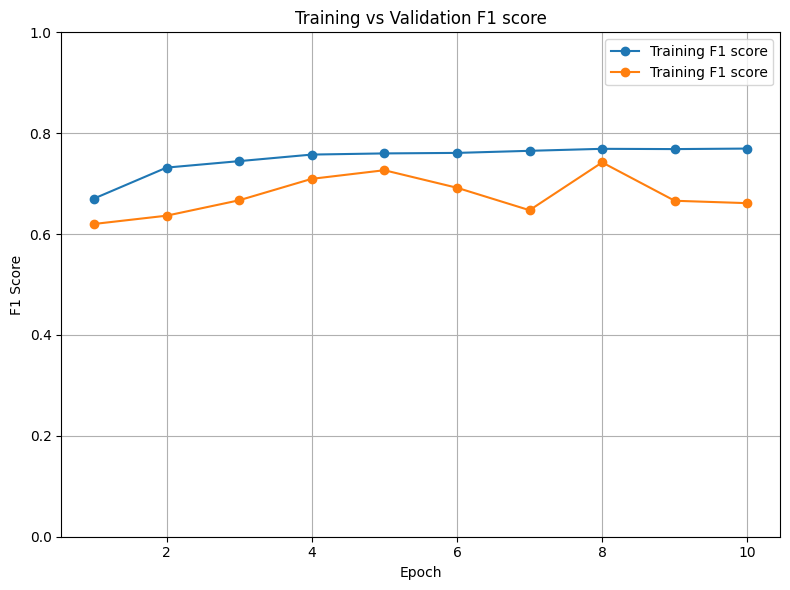

In [23]:
# Plot the loss and F1 score vs training epoch
epochs = range(1, len(all_training_f1) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, all_training_f1, label='Training F1 score', marker='o')
plt.plot(epochs, all_validation_f1, label='Training F1 score', marker='o')
plt.title('Training vs Validation F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Load the best model weights before validation
model.load_state_dict(torch.load(best_model_path, weights_only=True))

# Validation loop
model.eval()
test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions and actual labels
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        # Calculate accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [25]:
# Adding metrics of interest
avg_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total
print(f"Test Loss: {avg_test_loss:.4f} \nAccuracy: {accuracy:.2f}%")

# Calculate precision, F1 score, and confusion matrix
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Precision: {precision:.4f} \nRecall: {recall:.4f} \nF1 Score: {f1:.4f}")

Test Loss: 0.5044 
Accuracy: 75.65%
Precision: 0.7484 
Recall: 0.8050 
F1 Score: 0.7422


In [30]:
# Per-class metrics
class_names = ['Benign', 'Cancer']
per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)

print("Per-Class Metrics:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}:")
    print(f"  Precision: {per_class_precision[i]:.4f}")
    print(f"  Recall:    {per_class_recall[i]:.4f}")
    print(f"  F1 Score:  {per_class_f1[i]:.4f}")

Per-Class Metrics:
Benign:
  Precision: 0.9547
  Recall:    0.6928
  F1 Score:  0.8030
Cancer:
  Precision: 0.5420
  Recall:    0.9171
  F1 Score:  0.6814
